# Total Time and Sing Time

This evaluates the effect of various variables on *Total Time* and *Sing Time*.

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
reg_palette = sns.color_palette("colorblind", 5)
sns.set_palette(reg_palette)
light_palette = [sns.set_hls_values(x, l=0.65) for x in reg_palette]
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("../data/time.csv", index_col=0)
df

,User ID,Technique,Skill,Metric,Background,Training,Time,Success
0,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Total time,No-Music,Untrained,5852.5,True
1,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Sing time,No-Music,Untrained,4648.5,True
2,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Total time,No-Music,Untrained,1854.0,False
3,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Sing time,No-Music,Untrained,1150.9,False
4,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Total time,No-Music,Untrained,3846.9,True
...,...,...,...,...,...,...,...,...
6955,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Sing time,Music,Trained,3798.3,True
6956,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Total time,Music,Trained,4700.8,True
6957,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Sing time,Music,Trained,2551.7,True
6958,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Total time,Music,Trained,5903.9,True


In [34]:
%%R -i df

# Import libs for analysis
library(emmeans) # emmeans
library(ez) # ezANOVA

# Sanitize dataframe column names
library(janitor)
df <- clean_names(df)

df$user_id <- factor(df$user_id)
df$technique <- factor(df$technique)
df$skill <- factor(df$skill)
df$metric <- factor(df$metric)
df$background <- factor(df$background)
df$training <- factor(df$training)
df$success <- factor(df$success)

# Total Time stats

## Test for normality

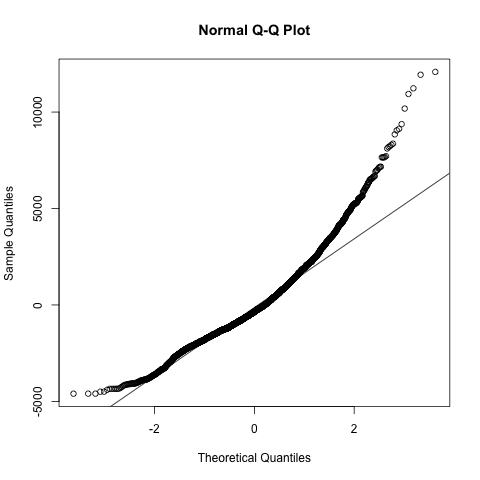

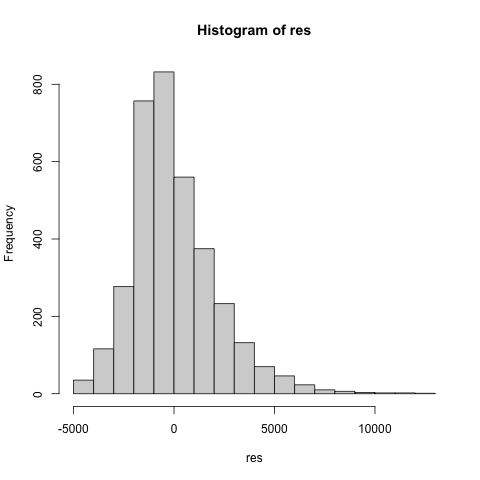

In [5]:
%%R
total_time_df <- subset(df, metric == "Total time")

m = aov(time ~ technique*skill, data=total_time_df)
res = residuals(m)
qqnorm(res)
qqline(res)
hist(res)

### BoxCox for pitch total time: .17

In [6]:
%%R
adj = .17
pitch_tt_df <- subset(total_time_df, technique == "Pitch")
pitch_tt_df$adj_time <- (pitch_tt_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = pitch_tt_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = pitch_tt_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = pitch_tt_df))
W = 0.92081, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = pitch_tt_df))
W = 0.99347, p-value = 5.562e-05



### BoxCox for interval total time: .25

In [7]:
%%R
adj = .25
interval_tt_df <- subset(total_time_df, technique == "Interval")
interval_tt_df$adj_time <- (interval_tt_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = interval_tt_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = interval_tt_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = interval_tt_df))
W = 0.93191, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = interval_tt_df))
W = 0.98853, p-value = 7.033e-08



### BoxCox for melody total time: .67

In [8]:
%%R
adj = .67
melody_tt_df <- subset(total_time_df, technique == "Melody")
melody_tt_df$adj_time <- (melody_tt_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = melody_tt_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = melody_tt_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = melody_tt_df))
W = 0.98394, p-value = 5.141e-10


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = melody_tt_df))
W = 0.9928, p-value = 2.012e-05



## Pitch: Background X Training X Skill ANOVA

In [9]:
%%R
suppressWarnings(ezANOVA(
    data = pitch_tt_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd       SSn       SSd        F          p
1                     skill   2  18 7.2535074 54.600867 1.195614 0.32543337
2                background   1  18 0.7458681  4.741366 2.831594 0.10969136
4                  training   1  18 0.9168442 11.866856 1.390697 0.25364053
3          skill:background   2  18 2.0608023  4.741366 3.911788 0.03884231
5            skill:training   2  18 1.6188051 11.866856 1.227726 0.31635221
6       background:training   1  18 0.8828803  8.176318 1.943643 0.18024587
7 skill:background:training   2  18 3.1320133  8.176318 3.447532 0.05400490
  p<.05         ges
1       0.083721126
2       0.009308078
4       0.011417416
3     * 0.025302618
5       0.019984209
6       0.010999117
7       0.037955784



### Pitch post-hoc: Skill X Background

In [10]:
%%R
contrast(emmeans(lm(adj_time ~ background * skill, data=pitch_tt_df), pairwise ~ background | skill))

$emmeans
skill = Expert:
 contrast          estimate     SE   df t.ratio p.value
 Music effect        0.0172 0.0962 1155   0.179  0.8583
 (No-Music) effect  -0.0172 0.0962 1155  -0.179  0.8583

skill = Intermediate:
 contrast          estimate     SE   df t.ratio p.value
 Music effect       -0.0681 0.1105 1155  -0.616  0.5380
 (No-Music) effect   0.0681 0.1105 1155   0.616  0.5380

skill = Novice:
 contrast          estimate     SE   df t.ratio p.value
 Music effect        0.2945 0.1028 1155   2.864  0.0043
 (No-Music) effect  -0.2945 0.1028 1155  -2.864  0.0043

P value adjustment: fdr method for 2 tests 

$contrasts
skill = Expert:
 contrast                    estimate SE   df t.ratio p.value
 (Music - (No-Music)) effect        0  0 1155     NaN     NaN

skill = Intermediate:
 contrast                    estimate SE   df t.ratio p.value
 (Music - (No-Music)) effect        0  0 1155     NaN     NaN

skill = Novice:
 contrast                    estimate SE   df t.ratio p.value
 (Music 

In [11]:
df[(df["Metric"] == "Total time") & (df["Technique"] == "Pitch")].groupby(
    ["Skill", "Background"]
).mean()

Time
Skill        Background             
Expert       Music       3987.667727
             No-Music    3994.381538
Intermediate Music       4846.380838
             No-Music    5092.031737
Novice       Music       5129.222396
             No-Music    4446.708247

## Interval: Background X Training X Skill ANOVA

In [12]:
%%R
suppressWarnings(ezANOVA(
    data = interval_tt_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd        SSn       SSd         F         p
1                     skill   2  18 17.5375877 143.63558 1.0988802 0.3545877
2                background   1  18  0.7192922  36.88915 0.3509775 0.5609296
4                  training   1  18  3.5742740  73.41246 0.8763762 0.3615872
3          skill:background   2  18  1.1372957  36.88915 0.2774708 0.7608801
5            skill:training   2  18  5.0546541  73.41246 0.6196753 0.5492105
6       background:training   1  18  0.5023048  14.28641 0.6328733 0.4366691
7 skill:background:training   2  18  0.5643779  14.28641 0.3555408 0.7056064
  p<.05         ges
1       0.061371484
2       0.002674516
4       0.013150486
3       0.004222201
5       0.018496364
6       0.001869209
7       0.002099714



## Melody: Background X Training X Skill ANOVA

In [13]:
%%R
suppressWarnings(ezANOVA(
    data = melody_tt_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd        SSn       SSd          F           p
1                     skill   2  18 13557.9655 238319.04  0.5120098 0.607759810
2                background   1  18   438.8836  38563.16  0.2048563 0.656236942
4                  training   1  18 24224.6655  30361.45 14.3617657 0.001341862
3          skill:background   2  18   993.6100  38563.16  0.2318920 0.795364378
5            skill:training   2  18  2273.0738  30361.45  0.6738040 0.522164126
6       background:training   1  18   442.8474  19900.20  0.4005615 0.534758066
7 skill:background:training   2  18  8736.5654  19900.20  3.9511713 0.037792110
  p<.05         ges
1       0.039794227
2       0.001339764
4     * 0.068943756
3       0.003028030
5       0.006900294
6       0.001351848
7     * 0.026010940



### Melody post-hoc: Training

In [14]:
%%R
pairs(emmeans(lm(adj_time ~ training, data=melody_tt_df), pairwise ~ training))

$emmeans
 contrast            estimate   SE   df t.ratio p.value
 Trained - Untrained    -33.7 6.72 1158  -5.016  <.0001


$contrasts
 contrast  estimate SE df z.ratio p.value
 (nothing)   nonEst NA NA      NA      NA




In [15]:
df[(df["Metric"] == "Total time") & (df["Technique"] == "Melody")].groupby(
    ["Training"]
).mean()

,Time
Training,
Trained,5072.966903
Untrained,5679.804713


### Melody post-hoc: Skill X Background X Training

In [16]:
%%R
contrast(emmeans(lm(adj_time ~ skill * background * training, data=melody_tt_df), pairwise ~ skill | background | training))

$emmeans
background = Music, training = Trained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect         -29.43 9.11 1148  -3.231  0.0019
 Intermediate effect    -9.96 9.79 1148  -1.018  0.3089
 Novice effect          39.39 9.45 1148   4.167  0.0001

background = No-Music, training = Trained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect          -9.61 9.09 1148  -1.057  0.6376
 Intermediate effect     2.12 9.77 1148   0.217  0.8286
 Novice effect           7.49 9.39 1148   0.798  0.6376

background = Music, training = Untrained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect           5.28 9.20 1148   0.574  0.8490
 Intermediate effect    -6.60 9.93 1148  -0.664  0.8490
 Novice effect           1.31 9.53 1148   0.138  0.8905

background = No-Music, training = Untrained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect         -21.99 9.24 1148  -2.381  0.0523
 Intermediate effect     2.69 9.84

In [17]:
df[
    (df["Metric"] == "Total time")
    & (df["Technique"] == "Melody")
    & (df["Background"] == "Music")
].groupby(["Skill", "Training"]).mean()

Time
Skill        Training              
Expert       Trained    4648.134375
             Untrained  5724.172136
Intermediate Trained    4992.298810
             Untrained  5563.519753
Novice       Trained    5876.321875
             Untrained  5665.326316

## Overall time for trained participants

In [18]:
df[(df["Metric"] == "Total time") & (df["Training"] == "Trained")].groupby(
    ["Skill", "Technique"]
).mean()

Time
Skill        Technique             
Expert       Interval   4275.735205
             Melody     4732.665201
             Pitch      3653.826786
Intermediate Interval   4770.284431
             Melody     5008.713095
             Pitch      4819.062275
Novice       Interval   5176.941753
             Melody     5521.535052
             Pitch      4651.605102

In [19]:
df[(df["Metric"] == "Total time") & (df["Training"] == "Trained")].groupby(
    ["Technique"]
).mean()

,Time
Technique,
Interval,4719.569328
Melody,5072.966903
Pitch,4318.492675


# Sing Time stats

## Test for normality

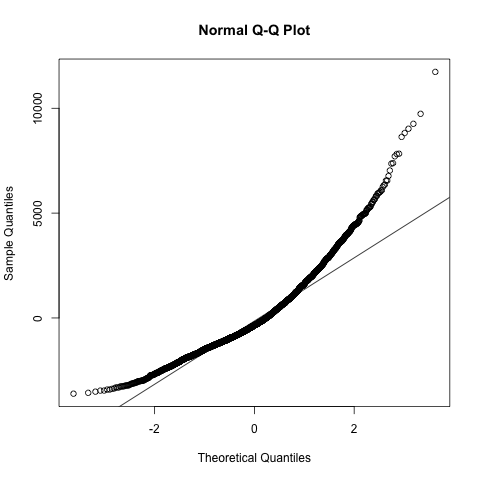

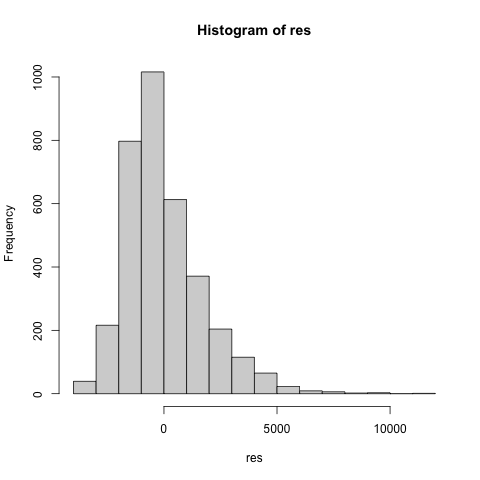

In [20]:
%%R
sing_time_df <- subset(df, metric == "Sing time")

m = aov(time ~ technique*skill, data=sing_time_df)
res = residuals(m)
qqnorm(res)
qqline(res)
hist(res)

### BoxCox for pitch sing time: .16

In [21]:
%%R
adj = .16
pitch_st_df <- subset(sing_time_df, technique == "Pitch")
pitch_st_df$adj_time <- (pitch_st_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = pitch_st_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = pitch_st_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = pitch_st_df))
W = 0.89013, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = pitch_st_df))
W = 0.99574, p-value = 0.00253



### BoxCox for interval sing time: .31

In [22]:
%%R
adj = .31
interval_st_df <- subset(sing_time_df, technique == "Interval")
interval_st_df$adj_time <- (interval_st_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = interval_st_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = interval_st_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = interval_st_df))
W = 0.92284, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = interval_st_df))
W = 0.99492, p-value = 0.0006027



### BoxCox for melody sing time: .58

In [23]:
%%R
adj = .58
melody_st_df <- subset(sing_time_df, technique == "Melody")
melody_st_df$adj_time <- (melody_st_df$time ^ adj - 1) / adj

print(shapiro.test(resid(lm(time ~ skill, data = melody_st_df))))
print(shapiro.test(resid(lm(adj_time ~ skill, data = melody_st_df))))


	Shapiro-Wilk normality test

data:  resid(lm(time ~ skill, data = melody_st_df))
W = 0.96884, p-value = 4.359e-15


	Shapiro-Wilk normality test

data:  resid(lm(adj_time ~ skill, data = melody_st_df))
W = 0.99326, p-value = 4.067e-05



## Pitch: Background X Training X Skill ANOVA

In [24]:
%%R
suppressWarnings(ezANOVA(
    data = pitch_st_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd        SSn       SSd         F           p
1                     skill   2  18 16.1732926 65.183602 2.2330714 0.136049180
2                background   1  18  3.2188928  6.235719 9.2916428 0.006919264
4                  training   1  18  1.8673445 15.211958 2.2095908 0.154461340
3          skill:background   2  18  0.5429396  6.235719 0.7836236 0.471720750
5            skill:training   2  18  3.0856768 15.211958 1.8256093 0.189719275
6       background:training   1  18  1.1868223 12.292976 1.7378055 0.203946946
7 skill:background:training   2  18  3.0394763 12.292976 2.2252778 0.136901657
  p<.05         ges
1       0.140518135
2     * 0.031513546
4       0.018526787
3       0.005458479
5       0.030248788
6       0.011855055
7       0.029809387



### Pitch post-hoc: Background

In [25]:
%%R
pairs(emmeans(lm(adj_time ~ background, data=pitch_st_df), pairwise ~ background))

$emmeans
 contrast           estimate    SE   df t.ratio p.value
 Music - (No-Music)    0.371 0.143 1159   2.589  0.0098


$contrasts
 contrast  estimate SE df z.ratio p.value
 (nothing)   nonEst NA NA      NA      NA




In [26]:
df[(df["Metric"] == "Sing time") & (df["Technique"] == "Pitch")].groupby(
    ["Background"]
).mean()

,Time
Background,
Music,2647.857392
No-Music,2407.166426


## Interval: Background X Training X Skill ANOVA

In [27]:
%%R
suppressWarnings(ezANOVA(
    data = interval_st_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd        SSn       SSd          F         p
1                     skill   2  18 32.8435261 529.78515 0.55794644 0.5819709
2                background   1  18  1.7961719 132.82379 0.24341343 0.6277170
4                  training   1  18  1.0349054 257.56810 0.07232377 0.7910412
3          skill:background   2  18  7.6060314 132.82379 0.51537668 0.6058271
5            skill:training   2  18 32.7510031 257.56810 1.14439258 0.3405243
6       background:training   1  18  4.1415912  85.21973 0.87478145 0.3620142
7 skill:background:training   2  18  0.1273685  85.21973 0.01345130 0.9866487
  p<.05          ges
1       0.0316338387
2       0.0017833444
4       0.0010282917
3       0.0075084011
5       0.0315475349
6       0.0041024605
7       0.0001266687



## Melody: Background X Training X Skill ANOVA

In [28]:
%%R
suppressWarnings(ezANOVA(
    data = melody_st_df,
    dv=.(adj_time),
    wid=.(user_id),
    within=.(background, training),
    between=.(skill),
    detailed=TRUE,
    type=1
))

$ANOVA
                     Effect DFn DFd        SSn       SSd         F          p
1                     skill   2  18 1048.08997 53545.850 0.1761632 0.83990935
2                background   1  18  450.27945  7474.946 1.0842927 0.31152433
4                  training   1  18 2730.69418  6496.754 7.5657000 0.01315600
3          skill:background   2  18  825.79763  7474.946 0.9942785 0.38942116
5            skill:training   2  18  602.04675  6496.754 0.8340196 0.45040473
6       background:training   1  18   26.13122  4544.241 0.1035073 0.75136682
7 skill:background:training   2  18 2358.85799  4544.241 4.6717862 0.02321428
  p<.05          ges
1       0.0143358180
2       0.0062097171
4     * 0.0365102742
3       0.0113297426
5       0.0082853695
6       0.0003624909
7     * 0.0316962831



### Melody post-hoc: Training

In [29]:
%%R
pairs(emmeans(lm(adj_time ~ training, data=melody_st_df), pairwise ~ training))

$emmeans
 contrast            estimate   SE   df t.ratio p.value
 Trained - Untrained    -11.3 3.22 1158  -3.500  0.0005


$contrasts
 contrast  estimate SE df z.ratio p.value
 (nothing)   nonEst NA NA      NA      NA




In [30]:
df[(df["Metric"] == "Sing time") & (df["Technique"] == "Melody")].groupby(
    ["Training"]
).mean()

,Time
Training,
Trained,3456.288319
Untrained,3861.866080


### Melody post-hoc: Skill X Background X Training

In [31]:
%%R
contrast(emmeans(lm(adj_time ~ skill * background * training, data=melody_st_df), pairwise ~ skill | background | training))

$emmeans
background = Music, training = Trained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect        -13.431 4.38 1148  -3.066  0.0033
 Intermediate effect   -2.871 4.71 1148  -0.610  0.5419
 Novice effect         16.302 4.55 1148   3.586  0.0010

background = No-Music, training = Trained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect         -0.348 4.37 1148  -0.080  0.9366
 Intermediate effect    1.548 4.70 1148   0.329  0.9366
 Novice effect         -1.200 4.52 1148  -0.266  0.9366

background = Music, training = Untrained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect          7.786 4.43 1148   1.759  0.1182
 Intermediate effect   -9.251 4.78 1148  -1.937  0.1182
 Novice effect          1.465 4.58 1148   0.320  0.7494

background = No-Music, training = Untrained:
 contrast            estimate   SE   df t.ratio p.value
 Expert effect         -7.403 4.44 1148  -1.667  0.2874
 Intermediate effect    3.806 4.73

In [32]:
df[
    (df["Metric"] == "Sing time")
    & (df["Technique"] == "Melody")
    & (df["Background"] == "Music")
].groupby(["Skill", "Training"]).mean()

Time
Skill        Training              
Expert       Trained    3111.799777
             Untrained  4094.470909
Intermediate Trained    3460.728571
             Untrained  3600.696296
Novice       Trained    4123.960417
             Untrained  3935.250526

# Overall time

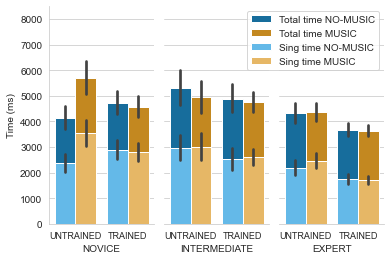

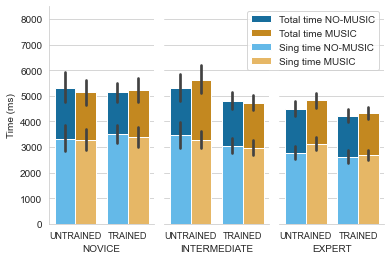

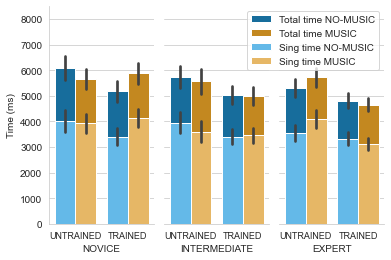

In [33]:
from utils.factorize import factorize_xticks, wrap_factor

skills = ["Novice", "Intermediate", "Expert"]
techniques = ["Pitch", "Interval", "Melody"]

for technique in techniques:
    fig = plt.figure(6)
    fig.set_figwidth(6)
    fig.set_figheight(4)
    gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.1)
    for col, classification in enumerate(skills):
        ax = fig.add_subplot(gs[0, col])
        for metric, palette in [("Total time", None), ("Sing time", light_palette)]:
            curr_df = pd.DataFrame(
                df[
                    (df["Technique"] == technique)
                    & (df["Skill"] == classification)
                    & (df["Metric"] == metric)
                ]
            )

            sns.barplot(
                data=curr_df,
                x="Training",
                order=["Untrained", "Trained"],
                y="Time",
                hue="Background",
                ci=95,
                n_boot=10000,
                ax=ax,
                #                 capsize=0.1,
                palette=palette,
            )

        ax.set_ylim(ymin=0, ymax=8500)
        ax.set_xlabel(wrap_factor(skills[col]))

        factorize_xticks(ax)

        if col != 2:
            ax.get_legend().set_visible(False)
        if col > 0:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        if col == 0:
            ax.set_ylabel("Time (ms)")
        if col == 2:
            for idx, text in enumerate(ax.legend().get_texts()):
                metric = "Total time" if idx < 2 else "Sing time"

                text.set_text(metric + r" " + wrap_factor(text.get_text()))

        # Remove spines
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        if col != 0:
            ax.spines["left"].set_visible(False)

        # Reduce tick label size for x axis
        ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), fontsize=9)

    plt.show()